In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
!pip install Cython
import torch
import sklearn.metrics as skm
from torch.autograd import Variable
import time

In [ ]:
df = pd.read_csv('/content/london_merged.csv')

In [ ]:
bike_data_df = df.dropna()
index = bike_data_df.timestamp.astype('datetime64[ns]')
bike_data = bike_data_df.set_index(pd.to_datetime(index))

In [ ]:
bike_data = bike_data.drop(columns=['timestamp','weather_code','is_holiday','is_weekend','season'])

In [ ]:
bike_data.head()

,cnt,t1,t2,hum,wind_speed
timestamp,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5


In [ ]:
bike_data_ = bike_data[16000:]
print(len(bike_data_))

1414


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f270ed0c4d0>,
      dtype=object)

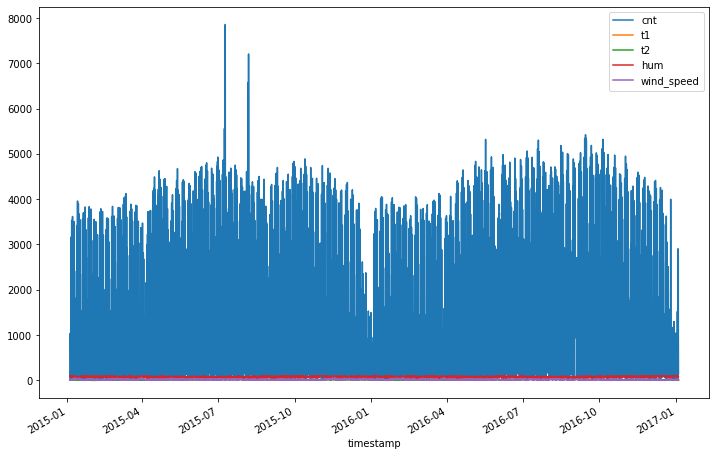

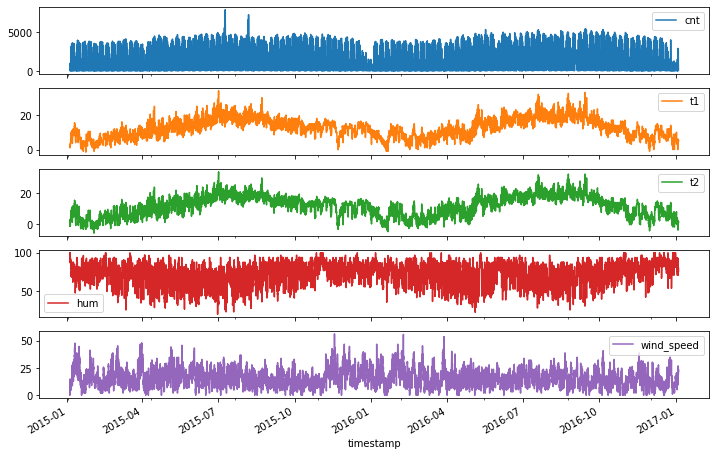

In [ ]:
bike_data.plot(figsize=(12,8))
bike_data.plot(subplots=True, figsize = (12,8))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f270d2b2390>,
      dtype=object)

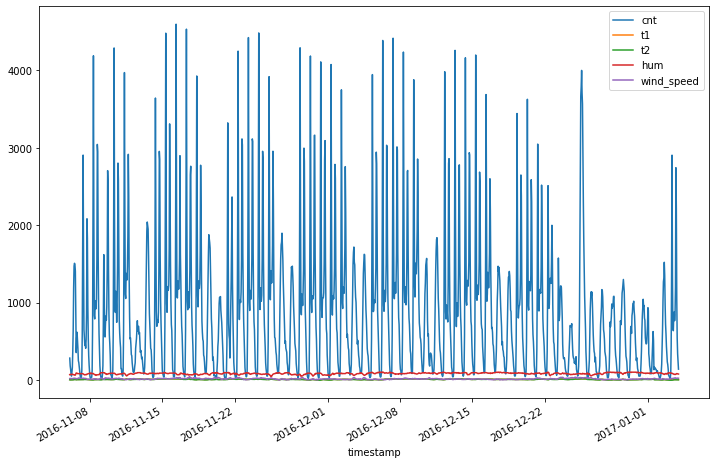

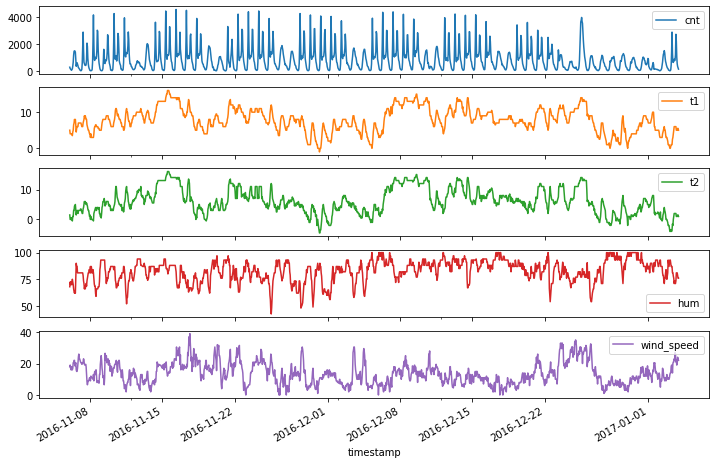

In [ ]:
bike_data_.plot(figsize=(12,8))
bike_data_.plot(subplots=True, figsize=(12,8))

In [ ]:


def custom_data_prep(data, window):
    x = []
    y = []

    for i in range(len(data)-window-1):
        _x = data[i:(i+window)]
        _y = data[i+window]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)



In [ ]:
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(bike_data_.values)
#window size of a week
window = 24

x, y = custom_data_prep(x_vals_scaled, window)
y = y[:,1]
y=np.array(y)[:,np.newaxis]
y.shape


(1389, 1)

In [ ]:

train_size = int(len(y) * 0.85)
val_size = int(train_size+(len(y)*0.10))
test_size = int(val_size+(len(y)*0.10))

print(train_size,val_size,test_size)
train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_size)

data_batch, target_batch = next(iter(trainloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0], data_batch.size(0))
print('Target:', target_batch[0])


val_x = Variable(torch.Tensor(np.array(x[train_size+1:val_size])))
val_y = Variable(torch.Tensor(np.array(y[train_size+1:val_size])))

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=val_size)

val_data_batch, val_target_batch = next(iter(valloader))
print(val_data_batch.size())
print(val_target_batch.size())
print('Training Window:', val_data_batch[0])
print('Target:', val_target_batch[0])

test_x = Variable(torch.Tensor(np.array(x[val_size+1:test_size])))
test_y = Variable(torch.Tensor(np.array(y[val_size+1:test_size])))

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_size)

test_data_batch, test_target_batch = next(iter(testloader))
print('test',test_data_batch.size())
print('test',test_target_batch.size())
print('Training Window:', test_data_batch[1],)
print('Target:', test_target_batch[1])

1180 1318 1456
torch.Size([1180, 24, 5])
torch.Size([1180, 1])
Training Window: tensor([[0.0595, 0.3529, 0.2927, 0.4435, 0.4615],
        [0.0377, 0.2941, 0.2195, 0.5217, 0.4872],
        [0.0279, 0.2941, 0.2195, 0.4783, 0.4359],
        [0.0150, 0.2941, 0.2439, 0.5217, 0.4103],
        [0.0087, 0.2941, 0.2195, 0.4783, 0.4615],
        [0.0192, 0.2941, 0.2439, 0.4783, 0.4103],
        [0.0327, 0.2647, 0.1951, 0.5652, 0.4103],
        [0.0787, 0.3235, 0.2683, 0.5217, 0.4359],
        [0.1397, 0.3529, 0.2683, 0.4783, 0.5256],
        [0.2562, 0.4412, 0.3659, 0.4087, 0.5256],
        [0.3187, 0.4706, 0.3659, 0.3652, 0.5641],
        [0.3266, 0.5294, 0.4390, 0.3391, 0.5641],
        [0.3227, 0.5000, 0.4390, 0.3739, 0.4744],
        [0.3046, 0.5294, 0.4634, 0.3391, 0.5000],
        [0.2027, 0.4412, 0.3659, 0.5826, 0.5256],
        [0.0750, 0.3235, 0.2927, 0.8261, 0.4103],
        [0.1166, 0.3824, 0.3415, 0.7739, 0.3846],
        [0.1323, 0.4118, 0.3659, 0.7739, 0.3846],
        [0.1105, 0.4

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state according to PyTorch documentation
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        
        
        out = self.fc(h_out[0])
        
        return out


In [ ]:
input_size = 5
hidden_size = 40
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(5, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


In [ ]:
epochs = 30
train_loss = []
val_loss = []

start = time.time()
for i in range(epochs):
  lstm_model.train()
  epoch_loss = 0.0
  for x,y in trainloader:
    
    optim.zero_grad()  

    y_pred = lstm_model(x)
    print(y_pred.shape)
    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    epoch_loss += single_loss.item()
    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train loss: {single_loss.item():10.8f}')

  lstm_model.eval()
  for x,y in valloader:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}validation loss: {single_loss.item():10.8f}')

end = time.time()

torch.Size([1180, 1])
torch.Size([1180, 1])
epoch:   1 train loss: 0.09577390
epoch:   1validation loss: 0.04448647
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])
epoch:  26 train loss: 0.00378203
epoch:  26validation loss: 0.00390236
torch.Size([1180, 1])
torch.Size([1180, 1])
torch.Size([1180, 1])


[0.3835639953613281, 0.09577389806509018, 0.019785722717642784, 0.01828179694712162, 0.03766290843486786, 0.0462704598903656, 0.030232056975364685, 0.013636848889291286, 0.010278311558067799, 0.008989342488348484, 0.012947220355272293, 0.0158576387912035, 0.00865213293582201, 0.007735987193882465, 0.00698313070461154, 0.008214211091399193, 0.006991549860686064, 0.006129228975623846, 0.0056369188241660595, 0.005360780283808708, 0.005931008141487837, 0.0046400646679103374, 0.004349655006080866, 0.004126633983105421, 0.004501240327954292, 0.004300030414015055, 0.003782029962167144, 0.0037357499822974205, 0.0036963708698749542, 0.003629811806604266]


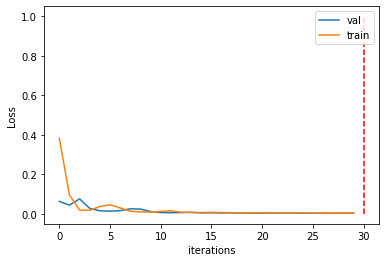

In [ ]:
print(train_loss)
fig, ax = plt.subplots()
ax.plot(val_loss,label="val")
ax.plot(train_loss,label="train")
ax.vlines(30, 0, 1, linestyles='dashed', colors='red')
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
lstm_model.eval()
for x_test,y_test in testloader:
  y_test_pred = lstm_model(x_test)
  
print(y_test_pred.shape)


torch.Size([70, 1])


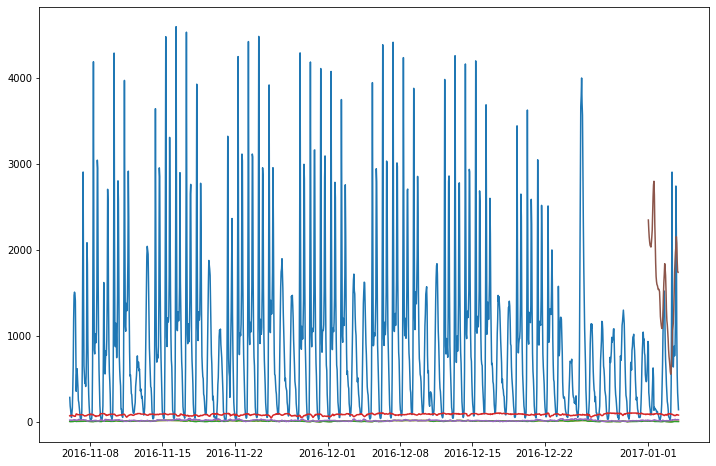

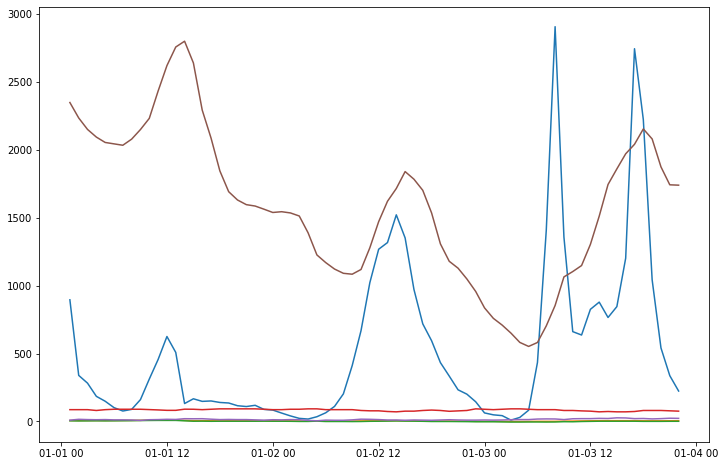

Mean squared error for 24 forecast steps: 1336.7807733501954
Mean absolute percentage error for 24 forecast steps: 10.5216197118874


In [ ]:
data_predict = y_test_pred.data.numpy()
data_predict.shape


bike_data_scaler = bike_data_['cnt']
test_bike_data = np.array(bike_data_scaler)[:, np.newaxis]
descaler = skp.MinMaxScaler()
test_vals_scaled = descaler.fit_transform(test_bike_data)
predictions_rescaled = descaler.inverse_transform(data_predict)


df = pd.DataFrame(predictions_rescaled, index=bike_data_.index[1343:1413])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_)
ax.plot(df)
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bike_data_.index[1343:1413], bike_data_.values[1343:1413])
plt.plot(df)
plt.show()

test_rescaled = test_bike_data[1343:1413]

rmse = skm.mean_squared_error(test_rescaled, predictions_rescaled, squared=False)
print("Mean squared error for 24 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled, predictions_rescaled)
print("Mean absolute percentage error for 24 forecast steps:", mape)